In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
identified_feaures_df = pd.read_pickle('/data/experiments/YHE/sequence-library/percolator-id-feature-mapping.pkl')

In [3]:
identified_feaures_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'feature_id', 'charge_y',
       'rt_apex', 'rt_peak_width', 'scan_apex', 'scan_peak_width', 'intensity',
       'precursor_id', 'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'percolator_idx', 'human'],
      dtype='object')

In [4]:
len(identified_feaures_df[identified_feaures_df['peptide mass'] <= 0])

3498

In [5]:
# remove the rubbish peptide masses
identified_feaures_df = identified_feaures_df[identified_feaures_df['peptide mass'] > 0]

In [6]:
len(identified_feaures_df)

564292

In [7]:
identified_features_from_runs_l = []
for group_name,group_df in identified_feaures_df.groupby(['sequence','charge_x'], as_index=False):
    file_ids_l = list(group_df.file_idx.unique())
    identified_features_from_runs_l.append((group_name[0], group_name[1], file_ids_l))

In [8]:
identified_features_from_runs_df = pd.DataFrame(identified_features_from_runs_l, columns=['sequence','charge','file_ids_identified'])

In [9]:
db_conn = sqlite3.connect('/data/experiments/YHE/target-decoy-models/experiment-metrics-for-library-sequences.sqlite')
extracted_features_df = pd.read_sql_query("select * from extracted_metrics", db_conn)
db_conn.close()

In [10]:
extracted_features_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'peak_idx',
       'target_metrics', 'attributes', 'decoy_metrics', 'peak_count'],
      dtype='object')

In [11]:
extracted_features_from_runs_l = []
for group_name,group_df in extracted_features_df.groupby(['sequence','charge'], as_index=False):
    file_ids_l = list(group_df.file_idx.unique())
    extracted_features_from_runs_l.append((group_name[0], group_name[1], file_ids_l))

In [12]:
extracted_features_from_runs_df = pd.DataFrame(extracted_features_from_runs_l, columns=['sequence','charge','file_ids_extracted'])

In [13]:
features_df = pd.merge(identified_features_from_runs_df, extracted_features_from_runs_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [14]:
features_df['runs_identified_not_extracted'] = features_df.apply(lambda row: list(set(row.file_ids_identified).difference(row.file_ids_extracted)), axis=1)
features_df['number_runs_identified'] = features_df.apply(lambda row: len(row.file_ids_identified), axis=1)
features_df['number_runs_extracted'] = features_df.apply(lambda row: len(row.file_ids_extracted), axis=1)
features_df['number_runs_identified_not_extracted'] = features_df.apply(lambda row: len(row.runs_identified_not_extracted), axis=1)
features_df['proportion_runs_identified_not_extracted'] = features_df.number_runs_identified_not_extracted / features_df.number_runs_identified

In [15]:
features_df.sample(n=10)

,sequence,charge,file_ids_identified,file_ids_extracted,runs_identified_not_extracted,number_runs_identified,number_runs_extracted,number_runs_identified_not_extracted,proportion_runs_identified_not_extracted
1652,ANVVVHCASPMHGQNPDIYDIVNVK,3,"[30, 28]","[16, 28, 4, 23, 15, 9, 25, 24, 27, 29, 14, 18,...",[],2,21,0,0.0
20002,NLANTVTEEILEK,2,"[6, 7, 17, 19, 18, 1, 24, 12, 2, 3, 29]","[16, 28, 4, 23, 17, 15, 9, 25, 24, 1, 27, 6, 2...",[],11,31,0,0.0
30302,VWSDMAVWNEDYCK,2,"[8, 11]","[16, 28, 4, 23, 17, 15, 9, 25, 24, 1, 27, 6, 2...",[],2,31,0,0.0
8789,FNVLQYVVPEVK,2,"[5, 1, 3, 4, 12, 2, 17, 7, 6, 19, 18, 26]","[16, 28, 4, 23, 17, 15, 9, 25, 24, 1, 27, 6, 2...",[],12,31,0,0.0
27072,TNLDESDVQPVK,2,[20],"[17, 15, 20, 12, 3, 2, 14, 18, 10, 19, 30, 7, ...",[],1,16,0,0.0
30161,VVITAPSSTAPM[15.9949]FVMGVNEEK,2,"[13, 24, 28, 8, 20, 30, 26, 9, 15, 16, 18]","[16, 28, 4, 23, 17, 15, 9, 25, 24, 1, 27, 6, 2...",[],11,31,0,0.0
7434,ESTLEAIGYICQDIDPEQLQDK,2,"[20, 28, 16, 22, 8, 30, 24, 9, 13, 14, 21, 0, ...","[16, 28, 4, 23, 17, 15, 9, 25, 24, 1, 27, 6, 2...",[],31,31,0,0.0
17213,LPSETIFVGCEFLHHLLR,3,"[22, 18, 16, 27, 10, 30, 24, 9, 21, 11, 20, 26...","[16, 28, 4, 23, 17, 15, 9, 25, 24, 1, 27, 6, 2...",[],17,31,0,0.0
1676,APEDFSQNWK,2,[17],"[16, 28, 4, 23, 17, 15, 9, 25, 24, 1, 27, 6, 2...",[],1,31,0,0.0
22331,Q[-17.0265]FANSNNNNNDSGNNNQGDYVTK,2,"[24, 11, 15, 0, 29, 20, 30, 13, 8, 22]","[16, 28, 23, 15, 9, 25, 24, 27, 20, 29, 14, 18...",[],10,21,0,0.0


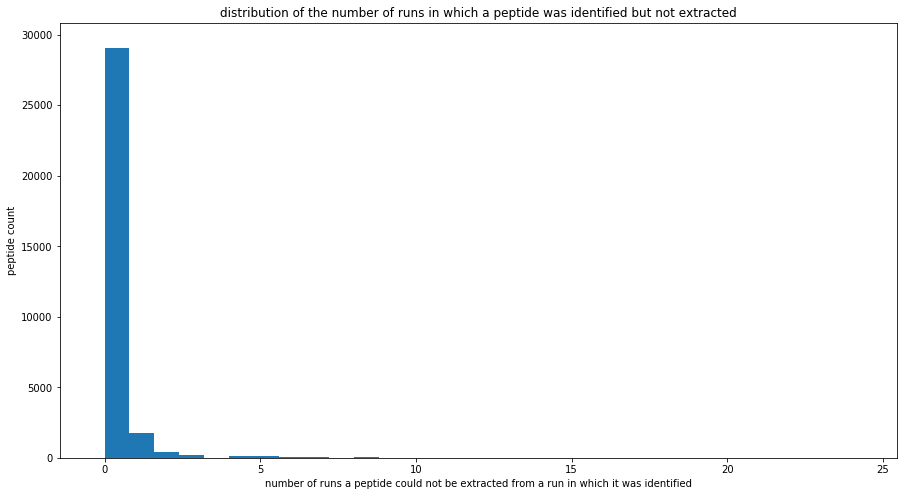

In [16]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 30
values = features_df.number_runs_identified_not_extracted
y, x, _ = ax1.hist(values, bins=bins)
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('number of runs a peptide could not be extracted from a run in which it was identified')
plt.ylabel('peptide count')
plt.title('distribution of the number of runs in which a peptide was identified but not extracted')
# plt.xlim((0,120))
# plt.ylim((0,600))

plt.show()

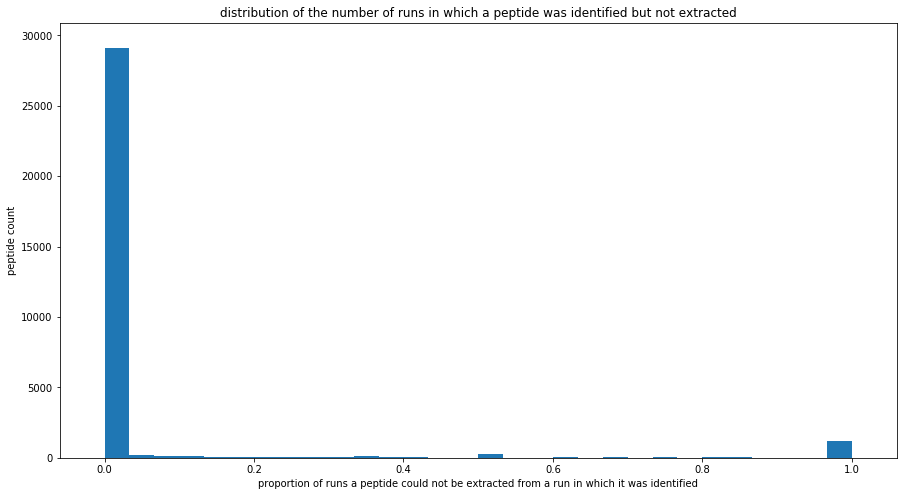

In [17]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 30
values = features_df.proportion_runs_identified_not_extracted
y, x, _ = ax1.hist(values, bins=bins)
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('proportion of runs a peptide could not be extracted from a run in which it was identified')
plt.ylabel('peptide count')
plt.title('distribution of the number of runs in which a peptide was identified but not extracted')
# plt.xlim((0,120))
# plt.ylim((0,600))

plt.show()

#### analyse the reasons for extraction failure in one of the runs

In [31]:
reasons_df = pd.read_csv('/home/ubuntu/reasons.csv', header=0, names=['reason','sequence','charge','run_name','file_id'])

In [32]:
reasons_df['reason'] = reasons_df.apply(lambda row: row.reason.split(': ')[1], axis=1)
reasons_df['sequence'] = reasons_df.apply(lambda row: row.sequence.split('sequence ')[1], axis=1)
reasons_df['charge'] = reasons_df.apply(lambda row: int(row.charge.split('charge ')[1]), axis=1)
reasons_df['file_id'] = reasons_df.apply(lambda row: int(row.file_id.split('file_id ')[1].split('.')[0]), axis=1)

In [33]:
reasons_df.sample(n=5)

,reason,sequence,charge,run_name,file_id
375,only found 1 isotopes,DLSYCLSGMYDHR,3,run YHE114_01_Slot1-1_1_3008,0
2872,only found 0 isotopes,YASICQQNGIVPIVEPEILPDGDHDLKR,4,run YHE114_01_Slot1-1_1_3008,0
2015,only found 0 isotopes,Q[-17.0265]GGSQPSSFSPGQSQVTPQDQEK,2,run YHE114_01_Slot1-1_1_3008,0
1508,only found 0 isotopes,LNLPINIIGLAPLCENM[15.9949]PSGK,3,run YHE114_01_Slot1-1_1_3008,0
818,only found 0 isotopes,GEETPVIVGSALCALEGR,3,run YHE114_01_Slot1-1_1_3008,0


In [21]:
file_id_of_interest = 2

In [22]:
failed_extracts_df = features_df[features_df.apply(lambda row: file_id_of_interest in row.runs_identified_not_extracted, axis=1)]
len(failed_extracts_df)

990

In [23]:
failed_extracts_reason_df = pd.merge(failed_extracts_df, reasons_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [30]:
failed_extracts_reason_df[['sequence','charge','reason']].sample(n=20)

,sequence,charge,reason
325,GPPALGTAGSR,2,only found 2 isotopes
43,ALADLVHSHIQSNELCSK,3,NaN
888,VGSLDNVGHLPAGGAVK,3,no L2 candidate peaks were found
172,DVATVAFCDAQSTQEIHEK,2,NaN
166,DSTLIMQLLR,2,NaN
224,ENAEVDGDDDAEEMEAK,2,no peaks were found in the monoisotopic peak f...
663,QVVQGLLSETYLEAHR,3,NaN
711,RFPELESLVPNALDYIR,3,only found 1 isotopes
892,VIAINVDDPDAANYNDINDVKR,3,NaN
682,Q[-17.0265]LEDCLILQTLLHSK,2,NaN


In [25]:
failed_extracts_reason_df.reason.value_counts()

no L2 candidate peaks were found                                              167
no peaks were found in the monoisotopic peak flattened to the RT dimension    146
only found 0 isotopes                                                          56
only found 2 isotopes                                                          53
only found 1 isotopes                                                          22
no points were found in the feature extraction region                          15
Name: reason, dtype: int64

#### now look at reasons overall, not just in extractions that failed for runs where the feature was identified

In [34]:
reasons_df.reason.value_counts()

only found 0 isotopes                                    1408
only found 2 isotopes                                     636
no points were found in the feature extraction region     494
only found 1 isotopes                                     447
Name: reason, dtype: int64